- references
    - https://mr-easy.github.io/2020-05-21-implementing-gibbs-sampling-in-python/
    - https://www.kaggle.com/code/paujac/gibbs-sampling-for-boltzmann-distribution

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## basics

- Gibbs采样，mc的一种。参数空间维度较高时，参数的联合概率分布，直接采样效率较低，可以通过 Gibbs 轮番采样
    - 所谓的轮番采样，每一步只更新一个变量，而保持其他变量固定。
    - 这种更新依赖于条件概率分布
- 吉布斯采样可以视为蒙特卡洛方法的一种特殊形式，具体来说，是马尔可夫链蒙特卡洛（MCMC）方法的一个特例。

## 2D Gassuian case

- 已知 2d 高斯分布
  
$$
\begin{split}
\mu = \left[\mu_x,\mu_y\right]\\
\Sigma=\begin{bmatrix}
\sigma_x^2 & \sigma_{xy}\\
\sigma_{xy} & \sigma_y^2
\end{bmatrix}
\end{split}
$$

- gibbs update
    - 更新 $X$ 的条件分布时的公式为：
$$
\begin{split}
&\mu_{x|y}=\mu_x+\frac{\sigma_{xy}}{\sigma_y^2}(y-\mu_y)\\
&\sigma_{x|y}^2=\sigma_x^2-\frac{\sigma_{xy}^2}{\sigma_y^2}
\end{split}
$$
  
    - 更新 $Y$ 的条件分布时的公式为：

 $$
\begin{split}
&\mu_{y|x}=\mu_y+\frac{\sigma_{xy}}{\sigma_x^2}(x-\mu_x)\\
&\sigma_{y|x}^2=\sigma_y^2-\frac{\sigma_{xy}^2}{\sigma_x^2}
\end{split}
$$
  

In [9]:
import torch

# 参数设置
mean = torch.tensor([0.0, 1])
# 设定协方差矩阵使其具有非零的协方差项，形成椭圆形状的高斯分布
cov = torch.tensor([[1.0, 0.8], [0.8, 1.0]])
num_samples = 1000

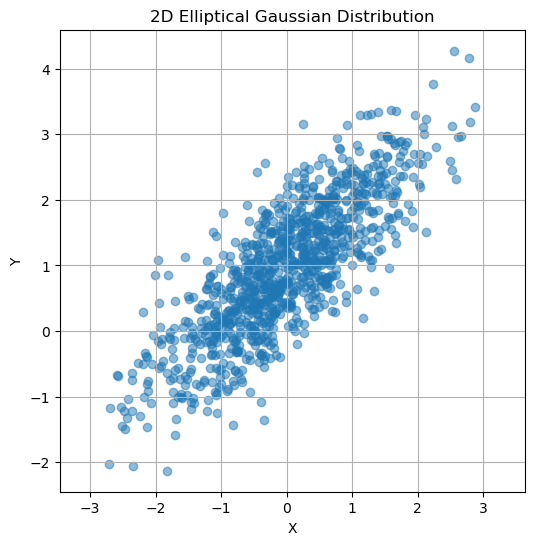

In [10]:
# 使用PyTorch的多变量正态分布生成样本
distribution = torch.distributions.MultivariateNormal(mean, cov)
samples = distribution.sample((1000,))  # 生成1000个样本

# 可视化结果
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title('2D Elliptical Gaussian Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')  # 确保两轴的刻度一致，以真实显示椭圆形状
plt.grid(True)

In [13]:
x, y = 0, 0
samples = torch.zeros(num_samples, 2)
for i in range(num_samples):
    # 更新x
    x_cond_mean = mean[0] + cov[0, 1] / cov[1, 1] * (y - mean[1])
    x_cond_var = cov[0, 0] - cov[0, 1] ** 2 / cov[1, 1]
    x = torch.normal(x_cond_mean, x_cond_var.sqrt())

    # 更新y
    y_cond_mean = mean[1] + cov[1, 0] / cov[0, 0] * (x - mean[0])
    y_cond_var = cov[1, 1] - cov[1, 0] ** 2 / cov[0, 0]
    y = torch.normal(y_cond_mean, y_cond_var.sqrt())

    samples[i, :] = torch.tensor([x, y])

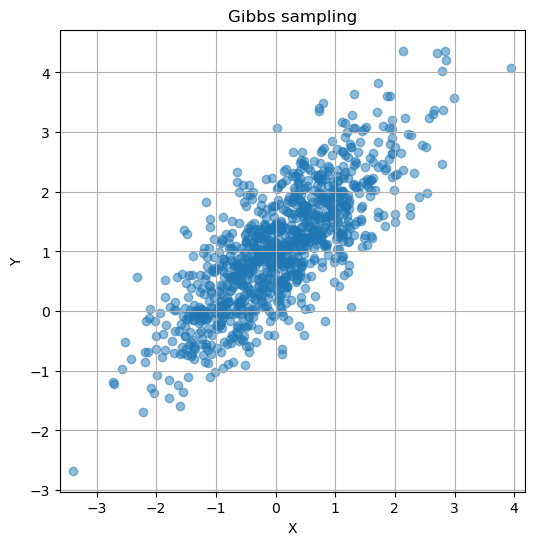

In [15]:
# 可视化结果
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title('Gibbs sampling')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')  # 确保两轴的刻度一致，以真实显示椭圆形状
plt.grid(True)

## gibbs vs. mcmc

- gibbs vs. mcmc
    - 核心概念：Gibbs采样和其他MCMC方法都基于构建一个马尔科夫链，使其平稳分布等于目标分布，通过对这个链进行采样来获得目标分布的样本。
    - 目的相同：两者都用于从复杂的或者高维的概率分布中采样，特别是当直接采样困难时。
    - 算法结构：Gibbs采样和MCMC都遵循相似的算法结构，包括初始化、迭代更新和收敛性判断。
- 区别
    - gibbs采样是一种特殊的MCMC方法，它通过逐个维度地更新所有变量来进行采样。在每一步中，Gibbs采样针对一个变量，固定其他变量，从该变量的条件分布中采样。
    - MCMC是一个更广泛的类别，包括多种采样方法，如Metropolis-Hastings (MH)算法、汉密尔顿蒙特卡罗（HMC）等。
        - mh 采样的核心是其接受-拒绝机制，用于决定是否接受新的样本点。
    - Gibbs采样适用于条件分布容易采样的情况，而MCMC的其他方法如Metropolis-Hastings则可以适用于更广泛的情况，即使条件分布不易直接采样。
    - 在某些情况下，Gibbs采样可能比其他MCMC方法更高效，因为它可以直接从条件分布中精确采样，避免了接受/拒绝步骤。但在条件分布难以计算或采样时，其他MCMC方法可能更优。

MH算法中，接受新状态 $x'$（从建议分布 $q(x'|x)$ 中采样）的概率 $\alpha(x,x')$ 可以表示为：

$$
\begin{split}
&\alpha(x,x')=\min\left(1, \frac{p(x')}{p(x)}\right)\\
&p(x)=\exp(-\frac12(x-\mu)^T\Sigma^{-1}(x-\mu))\\
&p(x')=\exp(-\frac12(x'-\mu)^T\Sigma^{-1}(x'-\mu))
\end{split}
$$

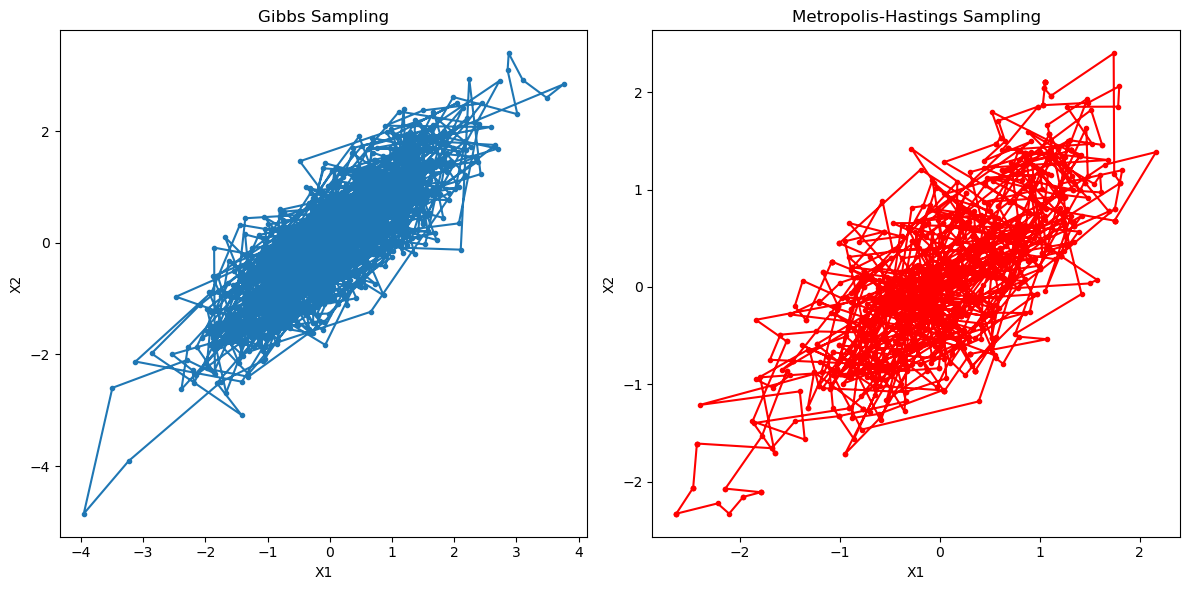

In [17]:

# 定义目标分布：二维高斯分布
mean = torch.zeros(2)
cov = torch.tensor([[1.0, 0.8], [0.8, 1.0]])

# 定义Gibbs采样函数
def gibbs_sampling(iterations):
    samples = torch.zeros((iterations, 2))
    x = torch.zeros(2)
    for i in range(iterations):
        x[0] = torch.normal(mean[0] + cov[0,1] / cov[1,1] * (x[1] - mean[1]), 
                            torch.sqrt(cov[0,0] - cov[0,1] ** 2 / cov[1,1]))
        x[1] = torch.normal(mean[1] + cov[1,0] / cov[0,0] * (x[0] - mean[0]), 
                            torch.sqrt(cov[1,1] - cov[1,0] ** 2 / cov[0,0]))
        samples[i] = x.clone()
    return samples

# 定义Metropolis-Hastings采样函数
def metropolis_hastings(iterations):
    samples = torch.zeros((iterations, 2))
    x = torch.zeros(2)
    for i in range(iterations):
        x_new = x + torch.normal(0, 0.5, size=(2,))
        if torch.exp(-0.5 * (x_new - mean).matmul(cov.inverse()).matmul(x_new - mean)) / \
           torch.exp(-0.5 * (x - mean).matmul(cov.inverse()).matmul(x - mean)) > torch.rand(1):
            x = x_new
        samples[i] = x
    return samples

# 执行采样
iterations = 1000
samples_gibbs = gibbs_sampling(iterations)
samples_mh = metropolis_hastings(iterations)

# 绘制采样结果
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(samples_gibbs[:, 0], samples_gibbs[:, 1], 'o-', markersize=3, label='Gibbs')
plt.title("Gibbs Sampling")
plt.xlabel("X1")
plt.ylabel("X2")

plt.subplot(1, 2, 2)
plt.plot(samples_mh[:, 0], samples_mh[:, 1], 'o-', markersize=3, color='red', label='Metropolis-Hastings')
plt.title("Metropolis-Hastings Sampling")
plt.xlabel("X1")
plt.ylabel("X2")

plt.tight_layout()


## 一个实际的做参数估计的例子

$$
y=ax+b+\epsilon, \quad \theta=(a,b,\epsilon)
$$